In [2]:
# import 

from logging import root
from skimage import color
from cmath import log
from hmac import trans_36
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import warnings
import deepgaze_pytorch
from PIL import Image

warnings.filterwarnings("ignore")

In [3]:

DEVICE = "cpu"

# image = face() #racoon face image load
train_path = "../data_sample"  


# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)


Loaded pretrained weights for efficientnet-b5


Using cache found in /Users/krc/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /Users/krc/.cache/torch/hub/pytorch_vision_v0.6.0


In [4]:
print(model)

DeepGazeIIE(
  (models): ModuleList(
    (0): DeepGazeIIIMixture(
      (features): FeatureExtractor(
        (features): RGBShapeNetA(
          (0): Normalizer()
          (1): Sequential(
            (module): ResNet(
              (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (layer1): Sequential(
                (0): Bottleneck(
                  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [5]:
# data preparation 


# image resize
resize_trans = transforms.Compose(
    [
        transforms.Resize((900, 900)),
        # transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.1, 2)),
        transforms.ToTensor(),
    ]
)

# with folder:
dataloader = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
print(dataloader)


Dataset ImageFolder
    Number of datapoints: 3099
    Root location: ../data_sample
    StandardTransform
Transform: Compose(
               Resize(size=(900, 900), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [242]:
dataloader[0][0].shape

torch.Size([3, 900, 900])

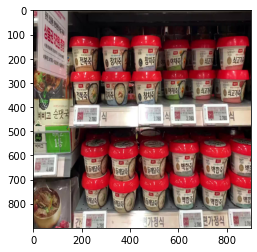

In [249]:
import matplotlib.pyplot as plt
plt.imshow(torch.transpose(dataloader[0][0], 0,2).transpose(0, 1))

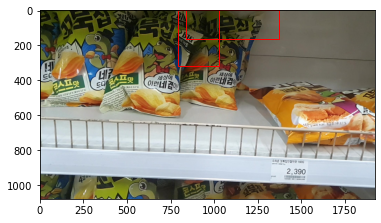

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots()
im = mpimg.imread('/Users/krc/Documents/retail/data/intuworks/dataset2_snack2/label/05-315.jpg')
ax.imshow(im)
x, y, w, h = np.array([0.535937 * 1920, 0.295139*1080, 0.123438*1920, 0.298611 *1080]) #center, w/2, h/2
a, b, c, d = rect1 =  np.array([0.575781 * 1920, 0.074306* 1080 , 0.139062 * 1920, 0.079167* 1080])
# Create a Rectangle patch
rect = patches.Rectangle((x-w, y-h), w*2,h*2, linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((a-c, b-d), c*2,d*2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)

plt.show()


In [7]:
loss_fn = torch.nn.BCELoss
optimizer = torch.optim.Adam(model.parameters(), 0.1,
                             weight_decay=0.05)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [231]:

def train_one_epoch(model = model, loss_fn = loss_fn, dataloader = dataloader, optimizer = optimizer, device = 'cpu'):

    model.train()

    train_loss = 0
    # 실시간 train_loss
    # 실시간 accuracy
    
    preds, trues = [], []
    dataset_size = 0

    bar = tqdm(enumerate(dataloader) , total = len(dataloader))
    for index, data in bar:
        x = data[0].to(device) # |bs, 3, 32, 32|
        print(x.shape)
        y_true = data[1].to(device) # |bs, 1|
        y_pred = model(x) # |bs, 10|
        y_pred = F.log_softmax(y_pred, dim =1)
        loss = loss_fn(y_pred, y_true)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 기존
        # train_loss += float(loss) # loss.item()
    # train_loss /= len(dataloader)
        
        # train_loss 실시간
        batch_size = x.shape[0]
        train_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        train_loss /= dataset_size
    
        bar.set_postfix(TRAIN_LOSS = train_loss)

In [232]:
from tqdm import tqdm

In [233]:

centerbias_template = np.load(
    "centerbias_mit1003.npy"
)  # on vsc ./deepgaze_sample/centerbias_mit1003.npy
# centerbias_template = np.ones((900, 900)) * (-16)

# rescale to match image size
centerbias = zoom(
    centerbias_template,
    (
        900 / centerbias_template.shape[0],
        900 / centerbias_template.shape[1],
    ),
    order=0,
    mode="nearest",
)
# renormalize log density
# centerbias -= logsumexp(centerbias)
centerbias_tensor = torch.tensor(centerbias).to(DEVICE)


In [234]:
train_one_epoch(model) # model =model.load_state_dict(centerbias)

0it [00:00, ?it/s]

torch.Size([3, 900, 900])


AttributeError: 'int' object has no attribute 'to'

In [221]:
model.centerbias = centerbias
model

DeepGazeIIE(
  (models): ModuleList(
    (0): DeepGazeIIIMixture(
      (features): FeatureExtractor(
        (features): RGBShapeNetA(
          (0): Normalizer()
          (1): Sequential(
            (module): ResNet(
              (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (layer1): Sequential(
                (0): Bottleneck(
                  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

---

In [9]:
import pandas as pd
centerbias_template = np.load(
    "centerbias_mit1003.npy"
) 

df_cb = pd.DataFrame(centerbias_template)
df_cb.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-17.500404,-17.501316,-17.503139,-17.505871,-17.509510,-17.514052,-17.519493,-17.525827,-17.533049,-17.541151,...,-23.349352,-23.470310,-23.557050,-23.638727,-23.713037,-23.778398,-23.833197,-23.875904,-23.905200,-23.920107
1,-17.501547,-17.502458,-17.504280,-17.507009,-17.510645,-17.515183,-17.520619,-17.526947,-17.534162,-17.542256,...,-23.343168,-23.463684,-23.550206,-23.631671,-23.705775,-23.770944,-23.825574,-23.868144,-23.897343,-23.912200
2,-17.503840,-17.504750,-17.506568,-17.509293,-17.512922,-17.517451,-17.522877,-17.529193,-17.536394,-17.544473,...,-23.332697,-23.452446,-23.538591,-23.619688,-23.693436,-23.758273,-23.812610,-23.854942,-23.883972,-23.898742
3,-17.507193,-17.508100,-17.509913,-17.512631,-17.516249,-17.520766,-17.526177,-17.532475,-17.539656,-17.547712,...,-23.314084,-23.432533,-23.518036,-23.598508,-23.671651,-23.735925,-23.789768,-23.831699,-23.860445,-23.875068
4,-17.511737,-17.512640,-17.514447,-17.517154,-17.520759,-17.525258,-17.530648,-17.536922,-17.544075,-17.552099,...,-23.289738,-23.406520,-23.491197,-23.570863,-23.643229,-23.706782,-23.759991,-23.801409,-23.829793,-23.844228


In [3]:
# centerbias recalculation on data samples


path = "../data_sample" 



resize_trans = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
dataloader = torchvision.datasets.ImageFolder(root=path, transform = resize_trans)
cb_0 = np.zeros((1080, 1920))
for idx, pics in enumerate(dataloader):
    image_rgb = pics[0]
    a = image_rgb[0].squeeze() # red
    b = image_rgb[1].squeeze() # green 
    c = image_rgb[2].squeeze() # blue 
    if np.array(a).shape != cb_0.shape or np.array(b).shape != cb_0.shape or np.array(c).shape != cb_0.shape:
        continue
    cb_0+= np.array( a+b+c )

new_cb = cb_0 / len(dataloader)

np.save("new_cb.npy", new_cb)
np.load("new_cb.npy")

array([[1.08413849, 1.08472438, 1.08618342, ..., 1.18453267, 1.1835431 ,
        1.18162218],
       [1.07944248, 1.07994865, 1.08105084, ..., 1.18491609, 1.18372026,
        1.18104008],
       [1.06992011, 1.07009981, 1.07065533, ..., 1.18465415, 1.18287116,
        1.18027956],
       ...,
       [1.56634844, 1.56668631, 1.56802134, ..., 1.44974157, 1.44652105,
        1.44242232],
       [1.5636227 , 1.56403017, 1.56553477, ..., 1.45223573, 1.44846095,
        1.44385985],
       [1.56114246, 1.56236487, 1.56421113, ..., 1.45078302, 1.44583772,
        1.44007368]])

In [8]:
import pandas as pd
centerbias_t = np.load(
    "new_cb.npy"
) 

df_cb = pd.DataFrame(centerbias_t*10-30)
df_cb.describe()

,0,1,2,3,4,5,6,7,8,9,...,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,-18.006128,-18.010181,-18.011370,-18.011582,-18.013441,-18.019587,-18.022952,-18.020680,-18.028095,-18.032265,...,-17.789793,-17.788690,-17.796811,-17.801903,-17.802151,-17.802692,-17.805278,-17.804256,-17.805294,-17.811224
std,1.370394,1.372889,1.372545,1.373783,1.374816,1.377233,1.379552,1.381453,1.381337,1.382636,...,1.143202,1.141392,1.144476,1.142913,1.141209,1.139765,1.137786,1.136294,1.133360,1.130159
min,-19.920657,-19.914153,-19.917468,-19.920189,-19.922568,-19.926769,-19.934653,-19.957734,-19.987485,-20.009022,...,-20.274269,-20.269536,-20.271194,-20.244974,-20.224082,-20.221817,-20.215161,-20.199128,-20.185676,-20.172908
25%,-19.130250,-19.132699,-19.126869,-19.124626,-19.133215,-19.141506,-19.143158,-19.136777,-19.152294,-19.154857,...,-18.701573,-18.695518,-18.712019,-18.720681,-18.721355,-18.712127,-18.706075,-18.703364,-18.708185,-18.721415
50%,-18.265601,-18.275895,-18.284000,-18.288075,-18.286936,-18.293795,-18.301799,-18.307930,-18.312359,-18.311916,...,-17.967706,-17.968484,-17.997867,-18.020424,-18.022442,-18.031958,-18.039772,-18.033749,-18.009725,-18.006903
75%,-17.459126,-17.467026,-17.468908,-17.468668,-17.472246,-17.477934,-17.481809,-17.475805,-17.478497,-17.485302,...,-17.079725,-17.073961,-17.088808,-17.074745,-17.081607,-17.084869,-17.083515,-17.087074,-17.078358,-17.079285
max,-13.944549,-13.945498,-13.954495,-13.967035,-13.987573,-14.007985,-14.019652,-14.028459,-14.061538,-14.057096,...,-15.183709,-15.192706,-15.204601,-15.218065,-15.228745,-15.240982,-15.257673,-15.259331,-15.266961,-15.281007


In [9]:
np.save("new_cb.npy",centerbias_t*10 - 30 )

In [331]:
len(dataloader)

3101